# Finding the magnetic dipole position with a convolutional neural net

## Instructions for notebook

The note book can be executed from top to bottom and it generates some output that allows to understand the how the data and models where generated <br>
The outputs are:
  1. data as .h5 file magnet settings as a .json file in '../data/' folder
  2. the model as a .h5 file in '../models/' folder
  3. the notebook as a .html file for future reference in '../html/' folder


Modify `generate_data()` to randomly change the z position and angles in addition to the x and y position.

**2019-01-21**: data for random xy positions with 2000 datapoints and shotnoise level 1, `tag = 'shot_noise_1_xy'`


## global notebook settings

In [1]:
calculate_data = True ## if true, data gets generated and saved to disk, if false load previous data from disk

calculate_learning_curve = False

n_train = 10000  # number of training examples (calculate_data=True)

n_val = 200  # number of validation examples (calculate_data=True)

is_colab = False  # if run in colab set this true

In [2]:
from pathlib import Path
import os

In [3]:
# setup the environment

if is_colab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  
  path_root = Path('/content/gdrive/My Drive/Colab Notebooks/')
  
  # install the pynvcenter package from github
  !pip install git+https://github.com/JanGieseler/pynvcenter.git
    
    
    
  from keras import backend as K
  print(K.tensorflow_backend._get_available_gpus())
else:
  path_root = Path('../')
  
  # for the local version we assume that pynvcenter is located in the parent dir of the notebook
  import sys,inspect
  currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
  parentdir = os.path.dirname(currentdir)
  sys.path.insert(0,parentdir) 

path_ipynb = path_root/'notebooks'
path_data = path_root/'data'
path_model = path_root/'models'
path_html = path_root/'html'

In [4]:

import pynvcenter.nv_analysis as nv_analysis
from sklearn.externals import joblib

In [5]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Reshape, Lambda, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers
from keras.optimizers import Adam

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tqdm import TQDMNotebookCallback
import time

from keras.utils.vis_utils import plot_model

from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt
from keras.models import load_model

%matplotlib inline

from tqdm import tqdm

import json

import h5py
%load_ext autoreload
%autoreload 2

from glob import glob
from joblib import Parallel, delayed

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# from google.colab import files
# uploaded = files.upload()

### define additinoal functions
this might be outsourced later

In [7]:
from pynvcenter.nn_utils import *

In [8]:
# magnet_parameters = {
#     'particle_radius':19,
#     'nv_radius':67, # 73.670
#     'theta_mag': 0,
#     'phi_mag': 60,
#     'dipole_height':80,
#     'shot_noise':0,
#     'linewidth':1e7,
#     'n_angle':48, # 45 48
#     'n_freq':448,  # 351
#     'f_min':2.62e9, #, 2.695
#     'f_max':3.120e9, #, 3.045
#     'avrg_count_rate':1
# }

# label_map = {'xo':'x', 'yo':'y', 'dipole_height':'z', 'theta_mag':'t', 'phi_mag':'p'}

# def create_image(xo, yo, plot_img=False, particle_radius=20, nv_radius=70, theta_mag=0, phi_mag=45,
#                                               dipole_height=80, shot_noise=0, linewidth=1e7,
#                                               n_angle=60, n_freq=300,
#                                               f_min=2.65e9, f_max=3.15e9,
#                                               avrg_count_rate=100):
#     """
#     xo, yo center of the circle
#     """
    
#     signal = nv_analysis.esr_2D_map_ring_scan(nv_x=xo, nv_y=yo,
#                                               particle_radius=particle_radius, nv_radius=nv_radius, theta_mag=theta_mag,
#                                               phi_mag=phi_mag,dipole_height=dipole_height, shot_noise=shot_noise,
#                                               linewidth=linewidth,n_angle=n_angle, n_freq=n_freq,
#                                               f_min=f_min, f_max=f_max,avrg_count_rate=avrg_count_rate,
#                                               return_data=True, show_plot=plot_img)


        
#     return signal
  
# def worker_function(parameters, pbar = None):

#     img = create_image(**parameters)  # calculate the image
#     if pbar:
#         pbar.update()  # update the progress
#     return img  # return the image


# def generate_data(n_data, parameters=None, n_jobs=2):

#     max_displacement = 20 ## maximum offset from the center 
#     # positive and negative values
#     positions = pd.DataFrame(max_displacement * (np.random.random((n_data, 2))-0.5),columns = ['xo', 'yo'])
    
#     positions['dipole_height'] = 20*(np.random.random((n_data)))+60
#     positions['theta_mag'] = 90*(np.random.random((n_data)))
#     positions['phi_mag'] = 90*(np.random.random((n_data)))
    
#     X = Parallel(n_jobs=n_jobs, backend='multiprocessing')(delayed(worker_function)({**parameters, **positions.iloc[i].to_dict()})
#                                                        for i in tqdm(range(len(positions))))
#     X = np.array(X,dtype=np.float16)
    
#     Y = positions.values
    
#     labels = positions.columns

    
# #     x_scaler = MinMaxScaler()
# #     # Xs = scaler.fit_transform(X.reshape(len(X), -1).astype(np.float32))
# #     x_scaler.fit(np.expand_dims(X.flatten().astype(np.float32), axis=1))  # flatten the array so that min_max scaling over full data and not for each feature (pixel)
    
# #     y_scaler = MinMaxScaler()
# #     y_scaler.fit(Y)
    

    
# #     {'X':X, 'Y' :Y, 'labels':labels, 'y_scaler':y_scaler, 'x_scaler':x_scaler}
#     return {'X':X, 'Y' :Y, 'labels':labels}



# def esr_preprocessing(X):
#     """
    
#     process data as we get it from a measuement such that we can use it to fit our model
    
#     esr has dips
#     here we subtract each esr map from its mean to obtain maps that have peaks instead of dips
    
#     X: matrix with dimensions (None, n_freq, n_angle) containing the esr data
#     """
    
#     x_shape = X.shape
#     assert len(x_shape)==3
    
#     mean = np.mean(X.reshape(x_shape[0], -1), axis=1)
    
#     return np.repeat(mean, np.product(x_shape[1:])).reshape(x_shape)-X
  
  
  

# def get_x_scaler(X, option=0):
#   """
  
#   create a scaler for X
#   option 1: normalize by min max of each feature, i.e. pixel
#   option 2: normalize by min max of entire dataset
  
#   """
    
#   if option==0:
#       x_scaler = None
#   elif option==1:
#       # option 1 (feature wise)
#       x_shape = X.shape
#       x_scaler = MinMaxScaler()
#       x_scaler.fit(X.reshape(x_shape[0], -1).astype(np.float32))
#   elif option==2:
#       # option 2 (global)
#       x_scaler = MinMaxScaler()
#       x_scaler.fit(np.expand_dims(X.flatten().astype(np.float32), axis=1))  # flatten the array so that min_max scaling over full data and not for each feature (pixel)

#   return x_scaler


# def split_and_scale(X, Y, x_scaler, y_scaler, test_size=0.1, option = 2):
#   """

#   x_scaler: tip - use get_x_scaler() to create scaler object
#   test_size: fraction for validation set
#   option: option use to create scaler in get_x_scaler()
#   """


#   x_shape = X.shape


#   if option==0:
#       Xs=X
#   elif option==1:
#       # option 1 (feature wise)
#       Xs = x_scaler.transform(X.reshape(x_shape[0], -1).astype(np.float32))
#   elif option==2:
#       # option 2 (global)
#       # flatten the array so that min_max scaling over full data and not for each feature (pixel)
#       Xs = x_scaler.transform(np.expand_dims(X.flatten().astype(np.float32), axis=1))  

#   Xs = Xs.reshape(x_shape)
#   Ys = y_scaler.transform(Y)

#   X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=test_size, random_state=42)

#   # add additional dimension since this is what the model expects (this is the "color channel")
#   X_train = np.expand_dims(X_train, -1)  
#   X_test = np.expand_dims(X_test, -1)

#   return X_train, X_test, Y_train, Y_test




# def analyze_fit(X, Y, model, magnet_parameters, n_plot=3, n_max=20, x_scaler=None, y_scaler=None):

    
#     if x_scaler:
#         x_shape = X.shape
#         Xs = x_scaler.transform(X.reshape(x_shape[0], -1).astype(np.float32)).reshape(x_shape)
#     else:
#         Xs=X

#     if y_scaler:
#         Ys = y_scaler.transform(Y)
#     else:
#         Ys = Y
        
        
#     if Xs.shape[-1] != 1: #model expects a dimension for "color channels"
#         Xs = np.expand_dims(Xs, -1)
        
#     Y_predict = model.predict(Xs)
    
# #     for k, v in magnet_parameters.items():
# #         print(k, v)
    
#     fig, ax = plt.subplots(1,2, figsize = (8,5))
        
#     for i in range(len(Xs)):
#         ax[0].plot([Ys[i, 0], Y_predict[i, 0]], [Ys[i, 1], Y_predict[i, 1]], 'go-', alpha=0.2)
#         ax[0].set_xlabel('xo')
#         ax[0].set_ylabel('yo')
#     ax[0].scatter(Ys[:n_max, 0], Ys[:n_max, 1], marker='o')
#     ax[0].scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
#     ax[0].set_title('scaled outputs')
    
    
#     if y_scaler:
#         Y_real = y_scaler.inverse_transform(Ys)
#         Y_pred_real = y_scaler.inverse_transform(Y_predict)
#     else:
#         Y_real = Ys
#         Y_pred_real = Y_predict

        
#     ax[1].scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
#     ax[1].scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
#     ax[1].set_xlabel('xo')
#     ax[1].set_ylabel('yo')
#     ax[1].set_title('physical outputs')
    
    
    

#     f_min=magnet_parameters['f_min']
#     f_max=magnet_parameters['f_max']
#     n_angle=magnet_parameters['n_angle']
#     n_freq=magnet_parameters['n_freq']
#     frequencies = np.linspace(f_min, f_max, n_freq)
#     angle = np.linspace(0, 360, n_angle)

#     if x_scaler:
#         x_shape = Xs.shape[0:-1]
#         X_real = x_scaler.inverse_transform(Xs.reshape(x_shape[0], -1)).reshape(x_shape)
#     else:
#         X_real = Xs

#     for i in range(n_plot):
#         fig, ax  = plt.subplots(1, 2, figsize = (12,4))

#         ax[0].pcolor(frequencies, angle, np.squeeze(X_real[i]))
#         ax[0].set_title('real\n' + ', '.join([label_map[k] +'={:0.2f}' for k in labels]).format(*Y_real[i]))
#         # and create the image, construction in second argument constructs the updates parameter dictionary
#         img = create_image(*Y_pred_real[i, 0:2], **{**magnet_parameters, **{k:v for k, v in zip(labels[2:], Y_pred_real[i, 2:])}})
#         ax[1].pcolor(frequencies, angle, img)
#         ax[1].set_title('reconstructed\n' + ', '.join([label_map[k] +'={:0.2f}' for k in labels]).format(*Y_pred_real[i]))
#         plt.tight_layout()

**show available data sets**

In [9]:
list(path_data.glob('*train*.h5'))

[PosixPath('../data/shot_noise_0_xyztpnr_train_001.h5'),
 PosixPath('../data/shot_noise_0_xyztpnr_train_000.h5'),
 PosixPath('../data/shot_noise_0_xyztpnr_train_002.h5')]

## start 

we ceate images of a circle with fixed linethickness and varying position and try to get the center position of the circle by fitting to a convolutional neural net

if the data has been generated before jump directly to  [load data](#load_data)


In [10]:
# calculate shotnoise

nmax = 1000000
c1 = 1000
shot_noise=300
x = np.random.poisson(lam=c1*shot_noise, size=nmax) / shot_noise
# x2 = np.random.poisson(lam=c1, size=nmax) / np.sqrt(shot_noise)
np.std(x)/c1, 1/(np.sqrt(c1)*np.sqrt(shot_noise))

(0.001827075296831628, 0.0018257418583505537)

## create the data

**set tag to describe current experiment**

In [11]:
# tag = 'shot_noise_2_xyzt'
tag = 'sim_data_20190125'

time_stamp = time.strftime('%Y%m%d-%H%M', time.localtime()) 
time_stamp

'20190130-1906'

In [12]:
# parameters for data from 20190125
magnet_parameters = {
    'particle_radius':(18, 4),
    'nv_radius':72.433, # 73.670, 72.433
    'theta_mag': (45, 90), # will be randomized between 
    'phi_mag': (45, 90),
    'dipole_height':(70, 20),
    'shot_noise':0,
    'linewidth':14e6,
    'n_angle':45, # 45 48
    'n_freq':200,  # 351
    'f_min':2.67e9, #,
    'f_max':3.068e9, #, 3.045
    'avrg_count_rate':1, 
    'xo':(0, 3),
    'yo':(0, 3)
}
XX = generate_data(2, parameters=magnet_parameters, n_jobs=3)

100%|██████████| 2/2 [00:00<00:00, 16.21it/s]


In [13]:
X = XX['X']; Y = XX['Y']; labels = XX['labels']

X.shape, labels

((2, 45, 200),
 Index(['particle_radius', 'theta_mag', 'phi_mag', 'dipole_height', 'xo', 'yo'], dtype='object'))

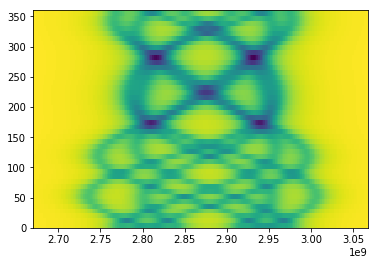

In [14]:
if calculate_data:
    f_min=magnet_parameters['f_min']
    f_max=magnet_parameters['f_max']
    n_angle=magnet_parameters['n_angle']
    n_freq=magnet_parameters['n_freq']
    frequencies = np.linspace(f_min, f_max, n_freq)
    angle = np.linspace(0, 360, n_angle)
#     img = x_scaler.inverse_transform(X.reshape(len(X), -1)).reshape(x_shape[0:-1])[0]
    img = X[0]
    plt.pcolor(frequencies, angle, img)
    


In [15]:
i = 0
while True:
    filename = str(path_data/(tag + '_--type--_{:03d}'.format(i)))
    if not os.path.isfile(filename.replace('--type--', 'train')+'.h5'):
        break
    else:
        i += 1
print(filename)

../data/sim_data_20190125_--type--_000


**generate the data**

In [16]:
os.cpu_count(), n_train

(4, 10000)

In [164]:
if calculate_data:

    print('generate training set')
    train_set = generate_data(n_train, parameters=magnet_parameters, n_jobs=3)

    X, Y = train_set['X'], train_set['Y']


  0%|          | 0/10000 [00:00<?, ?it/s]

generate training set



  0%|          | 9/10000 [00:02<51:33,  3.23it/s]

KeyboardInterrupt: 

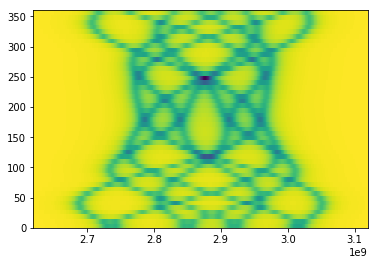

In [121]:
if calculate_data:
    print('genrate validation set')
    val_set = generate_data(n_val, n_jobs=3, parameters=magnet_parameters)

  0%|          | 0/200 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


### save the data set to disk

In [122]:
if calculate_data:
    print('saving the parameters (' + filename.replace('--type--', 'parameters')+'.h5' + ')')
    with open(filename.replace('--type--', 'parameters')+'.json', 'w') as outfile:
        json.dump(magnet_parameters, outfile)

saving the parameters (../data/shot_noise_0_xyztpnr_parameters_002.h5)


In [123]:
if calculate_data:
    print('saving the validation data (' + filename.replace('--type--', 'validation')+'.h5' + ')')
    
    hf = h5py.File(filename.replace('--type--', 'validation')+'.h5', 'w')
    hf.create_dataset("X",data=val_set['X'])
    hf.create_dataset("Y",data =val_set['Y'])
    hf.close()

saving the validation data (../data/shot_noise_0_xyztpnr_validation_002.h5)


In [124]:
# if calculate_data:

#     print('saving the scalers data (' + filename.replace('--type--', 'x_scaler') + ')')
#     joblib.dump(train_set['x_scaler'], filename.replace('--type--', 'x_scaler') + '.save') 
#     print('saving the scalers data (' + filename.replace('--type--', 'y_scaler') + ')')
#     joblib.dump(train_set['y_scaler'], filename.replace('--type--', 'y_scaler') + '.save') 

In [125]:
if calculate_data:

    print('saving the training data (' + filename.replace('--type--', 'train')+'.h5' + ')')

    hf = h5py.File(filename.replace('--type--', 'train')+'.h5', 'w')
    hf.create_dataset("X",data=train_set['X'])
    hf.create_dataset("Y",data =train_set['Y'])
    hf.close()

saving the training data (../data/shot_noise_0_xyztpnr_train_002.h5)


In [126]:
if calculate_data:
    print('saving the labels (' + filename.replace('--type--', 'labels') + '.txt' + ')')
    #Creating .csv file. 
    labels = open(filename.replace('--type--', 'labels') + '.txt',"w")
    labels.write(','.join(list(train_set['labels'])))
    labels.close()

saving the labels (../data/shot_noise_0_xyztpnr_labels_002.txt)


## load the data 
<a id="load_data"></a>

**show the avaliable data**

In [62]:
list(path_data.glob('*train*.h5'))

[PosixPath('../data/shot_noise_0_xyztpnr_train_001.h5'),
 PosixPath('../data/shot_noise_0_xyztpnr_train_000.h5'),
 PosixPath('../data/shot_noise_0_xyztp_train_001.h5'),
 PosixPath('../data/shot_noise_0_xyztp_train_000.h5')]

### settings
**define the file to be loaded** by defining the filename and tag

In [64]:
combine_data=True  ## if true concatenate all the dataset with the same name and only differing last three digits



filename = 'shot_noise_0_xyztpnr_--type--_000'
tag = filename.split('_--type')[0].split('/')[-1]
# filename = path_data/filename
filename

'shot_noise_0_xyztpnr_--type--_000'

### start loading the data

In [65]:
with open(path_data/(filename.replace('--type--', 'parameters')+'.json'), 'r') as infile:
    magnet_parameters =  json.load(infile)
magnet_parameters

{'particle_radius': 19,
 'nv_radius': 67,
 'theta_mag': 0,
 'phi_mag': 60,
 'dipole_height': 80,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 48,
 'n_freq': 448,
 'f_min': 2620000000.0,
 'f_max': 3120000000.0,
 'avrg_count_rate': 1}

In [109]:
if combine_data:
    val_set = None
    for f in path_data.glob( ('*'+ '_'.join((filename.replace('--type--', 'validation')+'.h5').split('_')[0:-1]) +'*')):
        print(f)
        hf = h5py.File(f, 'r')
        
        if val_set is None:
            val_set = {k: np.array(hf.get(k)) for k in hf.keys()}
        else:
            val_set = {k: np.vstack([val_set[k], np.array(hf.get(k))]) for k in hf.keys()}
            
        hf.close()

else:
    f = path_data/(filename.replace('--type--', 'validation')+'.h5')
    print(f)
    hf = h5py.File(f, 'r')
    val_set = {k: np.array(hf.get(k)) for k in hf.keys()}
    hf.close()

../data/shot_noise_0_xyztpnr_validation_000.h5
../data/shot_noise_0_xyztpnr_validation_001.h5


In [30]:
with open(path_data/(filename.replace('--type--', 'labels') + '.txt'),"r") as filein:
    labels = filein.read().split(',')
labels

['xo',
 'yo',
 'dipole_height',
 'theta_mag',
 'phi_mag',
 'particle_radius',
 'nv_radius']

In [114]:
if combine_data:
    train_set = None
    for f in path_data.glob( ('*'+ '_'.join((filename.replace('--type--', 'train')+'.h5').split('_')[0:-1]) +'*')):
        print(f)
        hf = h5py.File(f, 'r')
        
        if train_set is None:
            train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
        else:
            train_set = {k: np.vstack([train_set[k], np.array(hf.get(k))]) for k in hf.keys()}
            
        hf.close()

else:
    f = path_data/(filename.replace('--type--', 'train')+'.h5')
    print(f)
    hf = h5py.File(f, 'r')
    train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
    hf.close()



# hf = h5py.File(path_data/(filename.replace('--type--', 'train')+'.h5'), 'r')
# train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
# hf.close()

../data/shot_noise_0_xyztpnr_train_001.h5
../data/shot_noise_0_xyztpnr_train_000.h5


In [32]:
X, Y = train_set['X'], train_set['Y']

In [115]:
train_set['X'].shape

(15000, 48, 448)

### show the distributions

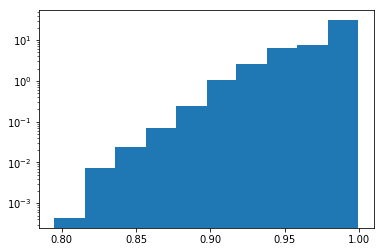

In [34]:
plt.hist(X.flatten(), log=True, density=True);

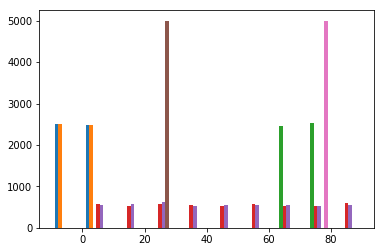

In [35]:
plt.hist(Y);

## CNN model - image in >> positions out

### define the model

In [36]:
# define base model
def baseline_model(input_shape, batch_norm=False):
    """VGG inspired model"""
    #create model
    model = Sequential()
    
    use_bias = batch_norm == False  # if batch_norm don't use bias
    #add model layers
    model.add(Conv2D(filters = 64, kernel_size=(3,3), use_bias=use_bias,  input_shape=(*input_shape, 1)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(filters = 128, kernel_size=(3,3), use_bias=use_bias))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(filters = 256, kernel_size=(3,3), use_bias=use_bias))
#     if batch_norm:
#         model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 256, kernel_size=(3,3), use_bias=use_bias))
#     if batch_norm:
#         model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 512, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
#     model.add(Dropout(rate=0.2))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(Y.shape[1]))
#     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam') # , metrics=['mse']
    return model
              
              
              
              
# define base model
# def baseline_model():
    
#     #create model
#     model = Sequential()
#     #add model layers
#     model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# #     model.add(Dropout(0.5))
#     model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
# #     model.add(Conv2D(2, kernel_size=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 256, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
# #     
    
#     model.add(Flatten())
#     model.add(Dense(100))
#     model.add(Dropout(0.5))
#     model.add(Dense(Y.shape[1]))
# #     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
#     return model
              


In [37]:
model = baseline_model(input_shape=X.shape[1:])

model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 446, 64)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 446, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 223, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 221, 128)      73856     
_________________________________________________________________
activation_2 (Activation)    (None, 21, 221, 128)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 110, 128)      0      

### create the train and test sets

In [38]:
added_noise = 0.005  # to a value larger 0 to add noise to the data, 0.01 corresponds to 1% noise level

scaler_option = 2


noise = added_noise*np.random.randn(*X.shape)
Xs = X + noise
Xs = esr_preprocessing(Xs)  

x_scaler = get_x_scaler(Xs, option=scaler_option)

y_scaler = MinMaxScaler()


y_scaler.fit(Y)


X_train, X_test, Y_train, Y_test = split_and_scale(Xs, Y, x_scaler, y_scaler, test_size=0.1,
                                                   option=scaler_option)

In [39]:

Y_train.shape

(4500, 7)

### show the distributions

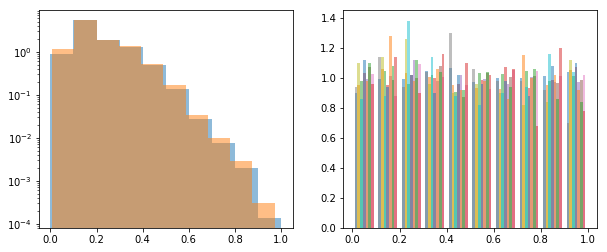

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].hist(X_train.flatten(), density=True, alpha=0.5, log=True)
ax[0].hist(X_test.flatten(), density=True, alpha=0.5, log= True)


ax[1].hist(Y_train, density=True, alpha=0.5);
ax[1].hist(Y_test, density=True, alpha=0.5);

### train the model - using Keras API

In [41]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

        
if is_colab:
  # Set callback functions to early stop training and save the best model so far
    callbacks = [
      EarlyStopping(monitor='val_loss', patience=5),
      ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
    ]
    history = model.fit(X_train,Y_train, epochs=64, batch_size=32,verbose=1,
                      validation_data=(X_test, Y_test),
                      callbacks=callbacks)
else:
  # Set callback functions to early stop training and save the best model so far
    callbacks = [
      EarlyStopping(monitor='val_loss', patience=5),
      ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
  #     LossHistory(),
      TQDMNotebookCallback(leave_inner=False, leave_outer=True)
    ]

    history = model.fit(X_train,Y_train, epochs=64, batch_size=32,verbose=0,
                      validation_data=(X_test, Y_test),
                      callbacks=callbacks)
# history = model.fit(X[0:200],Y[0:200], epochs=100, batch_size=32,verbose=1, validation_data=(val_set['X'], val_set['Y']))

KeyboardInterrupt: 

In [ ]:
plt.plot(X_train[0,10])

Text(0, 0.5, 'mean squared error')

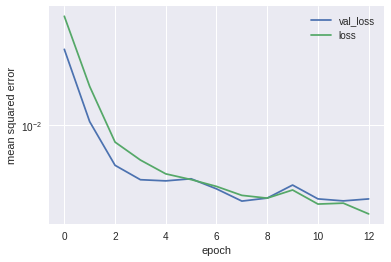

In [0]:
for value in ['val_loss', 'loss']:
    plt.semilogy(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

### save the model

In [0]:
time_stamp = time.strftime('%Y%m%d-%H%M', time.localtime()) 

f = str(path_model/(time_stamp+'_'+tag+'_model.h5'))
model.save(f)
print(f+' saved')
      
print('saving the scalers data ('+ f.replace('_model.h5', '_x_scaler.save')+ ')');
joblib.dump(x_scaler,f.replace('_model.h5', '_x_scaler.save'));
print('saving the scalers data ('+ f.replace('_model.h5', '_y_scaler.save')+ ')');
joblib.dump(y_scaler,f.replace('_model.h5', '_y_scaler.save'));

/content/gdrive/My Drive/Colab Notebooks/models/20190129-2145_shot_noise_0_xyztp_model.h5 saved
saving the scalers data (/content/gdrive/My Drive/Colab Notebooks/models/20190129-2145_shot_noise_0_xyztp_x_scaler.save)
saving the scalers data (/content/gdrive/My Drive/Colab Notebooks/models/20190129-2145_shot_noise_0_xyztp_y_scaler.save)


In [0]:
print('saving the labels (' + f.replace('_model.h5', '_labels.txt') + ')')
#Creating .csv file. 
labels_file = open(f.replace('_model.h5', '_labels.txt'),"w")
labels_file.write(','.join(list(labels)))
labels_file.close()

saving the labels (/content/gdrive/My Drive/Colab Notebooks/models/20190129-2145_shot_noise_0_xyztp_labels.txt)


### load the model

In [0]:
list(path_model.glob('*_model*'))

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/models/20190129-2106_shot_noise_0_xyztp_model.h5')]

In [0]:
model_name = '20190129-2106_shot_noise_0_xyztp_model.h5'

In [0]:
# load_model

model = load_model(str(path_model/model_name))

In [0]:
# load the scaler
x_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_x_scaler.save'))  
y_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_y_scaler.save')) 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 446, 64)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 446, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 223, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 221, 128)      73856     
_________________________________________________________________
activation_2 (Activation)    (None, 21, 221, 128)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 110, 128)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 108, 256)       295168    
__________

### show how well the model fits

#### on the training data

In [0]:
n_max = 10

x_shape = X_train[0:n_max].shape
Xo = x_scaler.inverse_transform(X_train[0:n_max].reshape(x_shape[0], -1)).reshape(x_shape)
Yo = y_scaler.inverse_transform(Y_train[0:n_max])

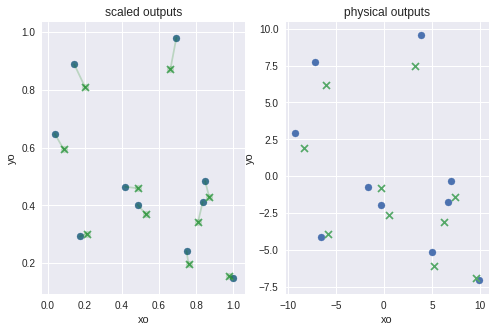

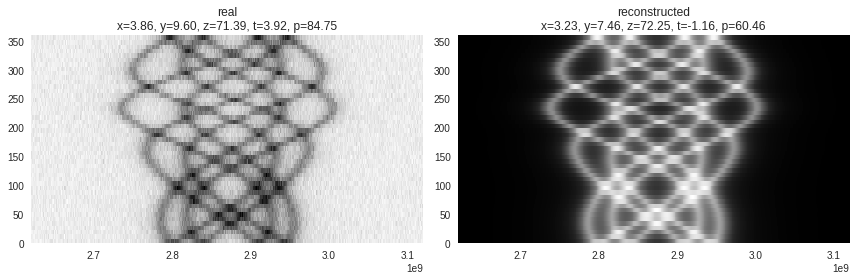

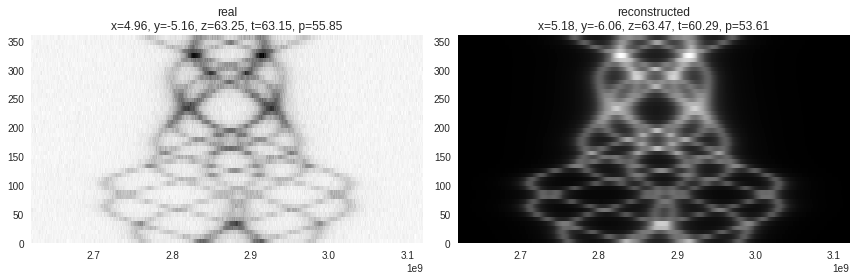

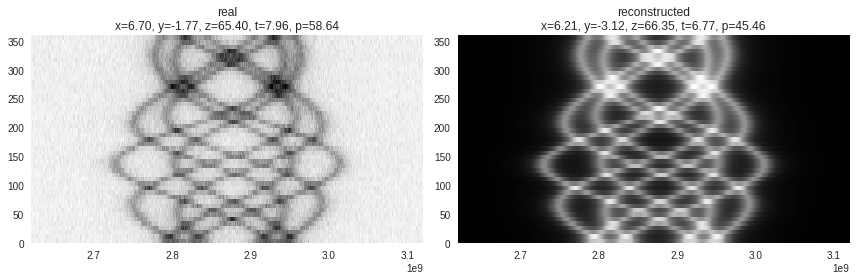

In [0]:
analyze_fit(Xo, Yo, model=model, magnet_parameters=magnet_parameters, n_max = n_max, x_scaler=x_scaler, y_scaler=y_scaler)

In [0]:
Y_pred = model.predict(X_train)

Text(0.5, 1.0, 'error distribution on train set')

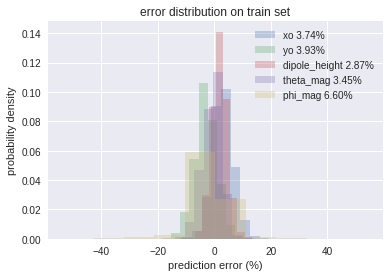

In [0]:
err = (Y_pred- Y_train)

for e, l in zip(err.T, labels):
    plt.hist(e*100, density=True, alpha=0.3, label = l+' {:0.2f}%'.format(100*np.std(e)))
plt.legend()
plt.xlabel('prediction error (%)')
plt.ylabel('probability density')
plt.title('error distribution on train set')

#### on the test data

In [0]:
x_shape = X_test[0:n_max].shape
Xo = x_scaler.inverse_transform(X_test[0:n_max].reshape(x_shape[0], -1)).reshape(x_shape)
Yo = y_scaler.inverse_transform(Y_test[0:n_max])

particle_radius 19
nv_radius 67
theta_mag 0
phi_mag 60
dipole_height 80
shot_noise 0
linewidth 10000000.0
n_angle 48
n_freq 448
f_min 2620000000.0
f_max 3120000000.0
avrg_count_rate 1


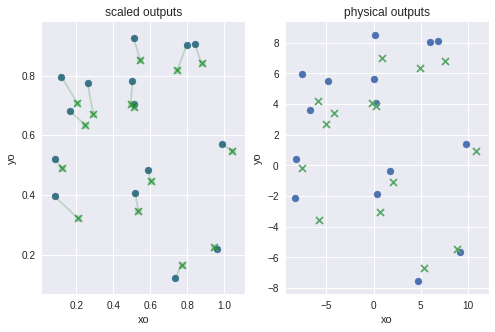

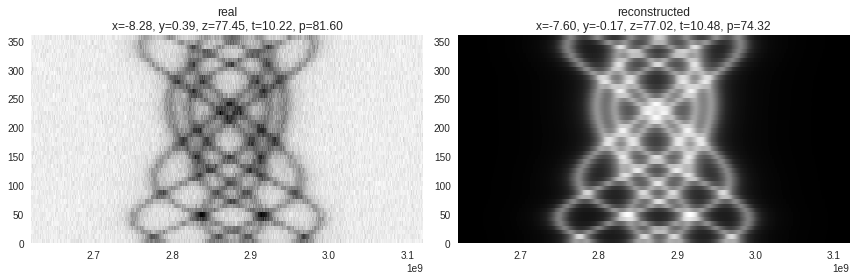

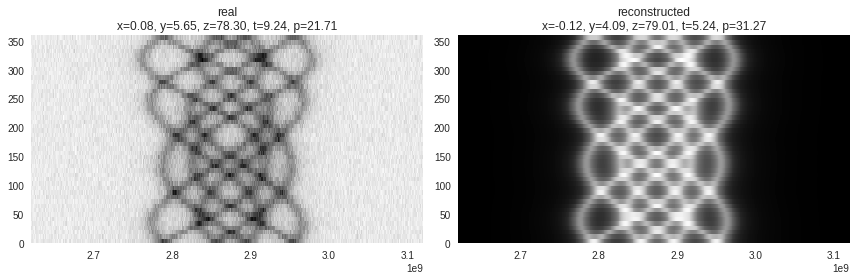

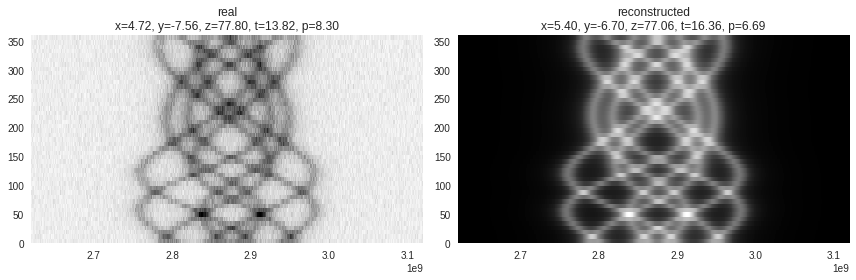

In [0]:
analyze_fit(Xo, Yo, model=model, magnet_parameters=magnet_parameters, n_max = 15, x_scaler=x_scaler, y_scaler=y_scaler)

In [0]:
Y_pred = model.predict(X_test)

Text(0.5, 1.0, 'error distribution on test set')

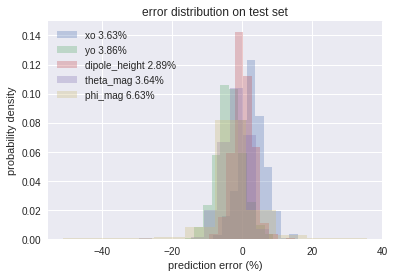

In [0]:
err = (Y_pred- Y_test)

for e, l in zip(err.T, labels):
    plt.hist(e*100, density=True, alpha=0.3, label = l+' {:0.2f}%'.format(100*np.std(e)))
plt.legend()
plt.xlabel('prediction error (%)')
plt.ylabel('probability density')
plt.title('error distribution on test set')

#### on the validation data

In [0]:
print('genrate validation set')
val_set = generate_data(n_max, n_jobs=3, parameters=magnet_parameters)

  0%|          | 0/15 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 15/15 [00:20<00:00,  2.14s/it]


In [0]:
Xo = val_set['X']
Yo = val_set['Y']

Xo = esr_preprocessing(Xo)

print(Xo.min(), Xo.max())

-0.02246 0.1694


particle_radius 19
nv_radius 67
theta_mag 0
phi_mag 60
dipole_height 80
shot_noise 0
linewidth 10000000.0
n_angle 48
n_freq 448
f_min 2620000000.0
f_max 3120000000.0
avrg_count_rate 1


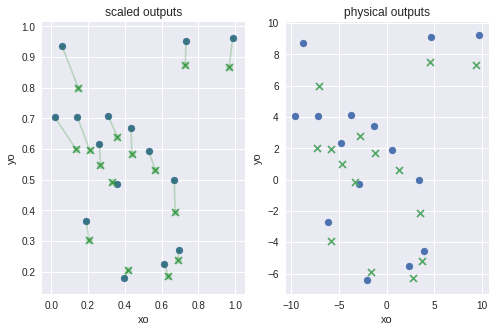

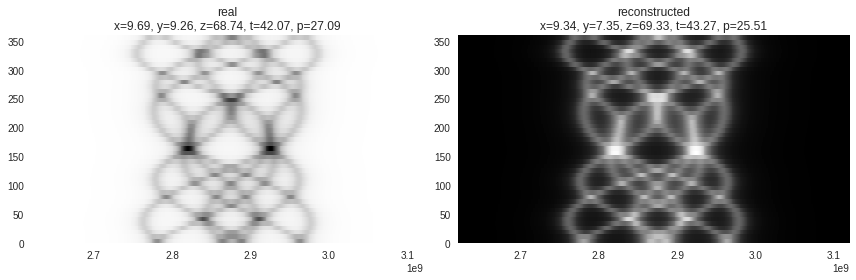

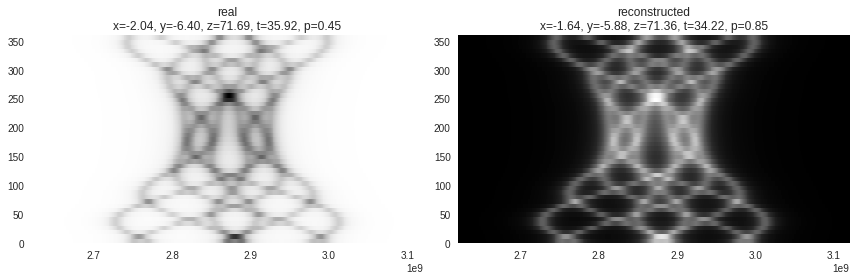

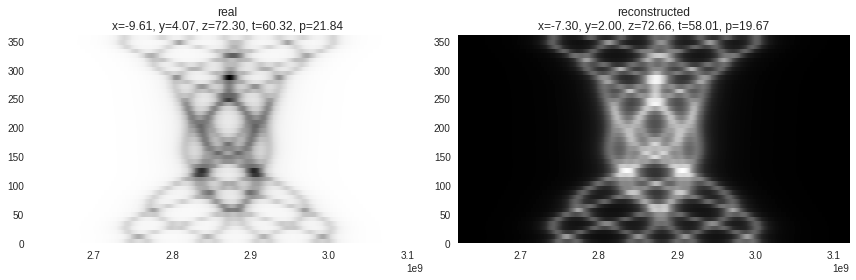

In [0]:
analyze_fit(Xo, Yo, model=model, magnet_parameters=magnet_parameters, n_max = 15, x_scaler=x_scaler, y_scaler=y_scaler)

#### on the test data - with noise

In [0]:
print('genrate validation set')
val_set = generate_data(n_max, n_jobs=3, parameters=magnet_parameters)


noise = 0.005*np.random.randn(*val_set['X'].shape)
Xo = val_set['X'][0:n_max]+noise
Yo = val_set['Y']

Xo = esr_preprocessing(Xo)

print(Xo.min(), Xo.max())


  0%|          | 0/15 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 15/15 [00:19<00:00,  2.49s/it]


-0.04431190951168085 0.1657716295632783


particle_radius 19
nv_radius 67
theta_mag 0
phi_mag 60
dipole_height 80
shot_noise 0
linewidth 10000000.0
n_angle 48
n_freq 448
f_min 2620000000.0
f_max 3120000000.0
avrg_count_rate 1


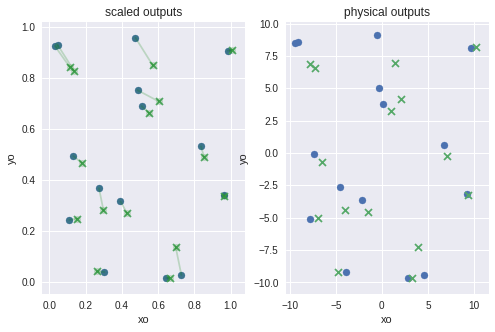

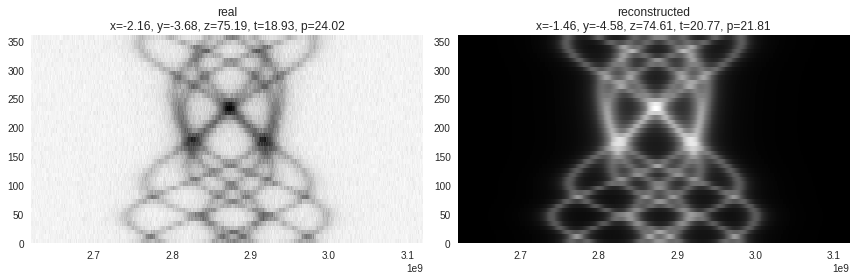

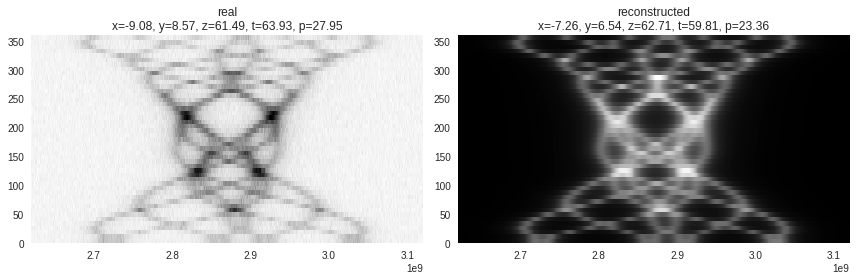

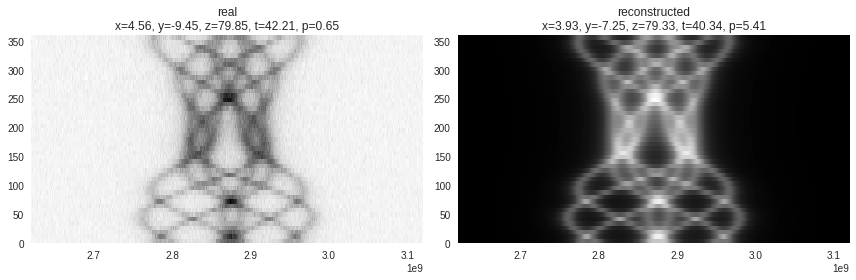

In [0]:
analyze_fit(Xo, Yo, model=model, magnet_parameters=magnet_parameters, n_max = 15, x_scaler=x_scaler, y_scaler=y_scaler)

### on data with slightly different parameters

In [0]:
n_max = 5

magnet_parameters_new = {**magnet_parameters, 'particle_radius': 18}

print('genrate validation set')
val_set = generate_data(n_max, n_jobs=3, parameters={**magnet_parameters, 'particle_radius': 18})


noise = 0.02*np.random.randn(*val_set['X'].shape)
Xo = val_set['X'][0:n_max]+noise
Yo = val_set['Y']

Xo = esr_preprocessing(Xo)

print(Xo.min(), Xo.max())

  0%|          | 0/5 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


-0.10621936516247688 0.2030780250868206


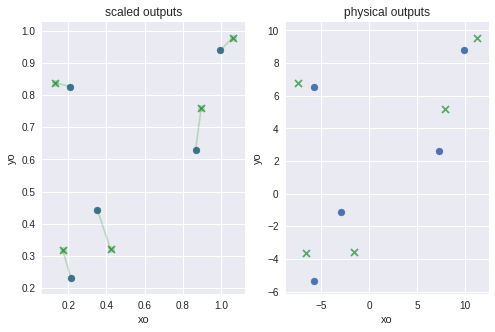

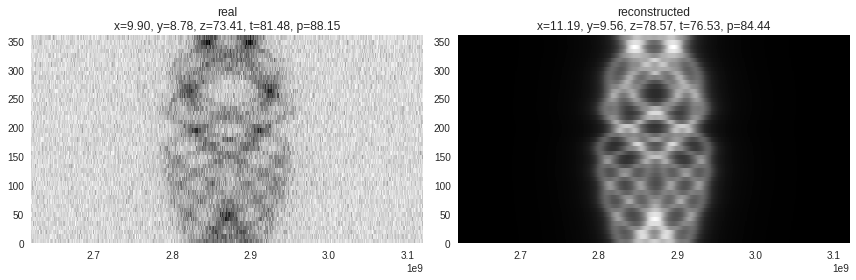

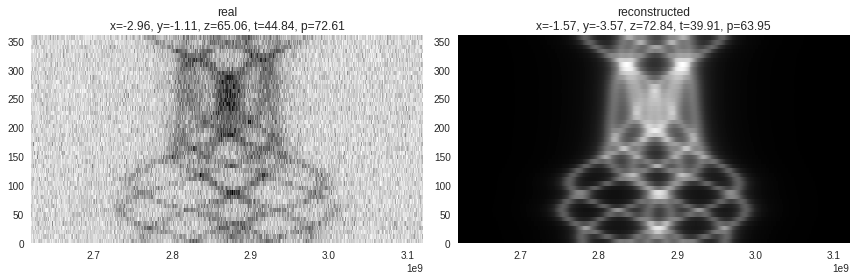

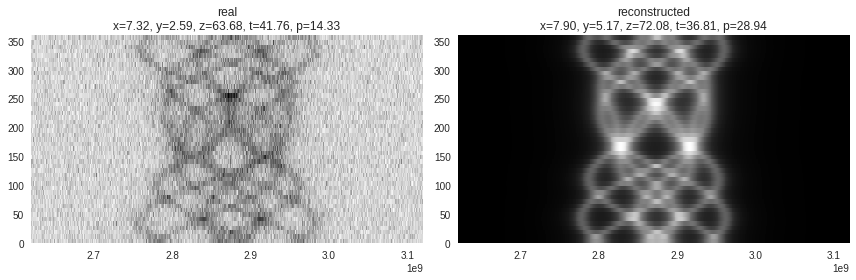

In [0]:
analyze_fit(Xo, Yo, model=model, magnet_parameters=magnet_parameters_new, n_max = n_max, x_scaler=x_scaler, y_scaler=y_scaler)

## Autoencoder

In [0]:
initializer = 'he_normal' # he_normal, glorot_normal
def define_encoder_block(x, num_filters, kernel_initializer=initializer):
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x)
    x = MaxPooling2D()(x)
    return x


def define_decoder_block(x, num_filters, kernel_initializer=initializer):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = kernel_initializer)(x)
    return x


def define_net(variational, height, width, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8):
    """Defines a (variational) encoder-decoder architecture.

    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.

    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """

    # Prepare the inputs.
    inputs = Input((height, width, 1))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs

    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters * 2)
    eblock3 = define_encoder_block(eblock2, start_filters * 4)
    eblock4 = define_encoder_block(eblock3, start_filters * 8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)

    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon

        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)

    dblock1 = define_decoder_block(embedding, start_filters * 8)
    dblock2 = define_decoder_block(dblock1, start_filters * 4)
    dblock3 = define_decoder_block(dblock2, start_filters * 2)
    dblock4 = define_decoder_block(dblock3, start_filters)
#     output = Conv2D(1, 1, activation='sigmoid')(dblock4)  # reduce down to one filter
    output = Conv2D(1, 1)(dblock4)  # reduce down to one filter

    # Define the models.
    decoder = Model(input=inputs_embedding, output=output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input=[inputs, condition], output=z)
        encoder_with_sampling_ext = Model(input=[inputs, condition], output=z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input=[inputs, condition], output=vae_out)
    else:
        encoder_with_sampling = Model(input=inputs, output=z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input=inputs, output=vae_out)

    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1, 2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss

    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')
#         vae.compile(loss='binary_crossentropy', optimizer='adam')

    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder




def load_weights(folder):
    vae.load_weights(folder + '/vae.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')


def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    vae.save_weights(folder + '/vae.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')
    
    
    


### train the autoencoder - using Keras API

In [0]:
X.shape

(5000, 48, 224, 1)

In [0]:
# noise= np.random.normal(loc=0,scale=0.1, size=X[50,:,:,0].shape)
# i = 30
# plt.imshow(X[0,:,:,0])
# print(Y[i])

In [0]:
# X = X[:,0:32, 0:336, :]

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [0]:
img_height, img_width= X_train.shape[1:3]
img_height, img_width

(48, 224)

In [0]:
vae, encoder, decoder = define_net(
    False, img_height, img_width, batch_size=8, latent_dim=16, start_filters=32)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:101: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


done, 3287761 parameters.


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [0]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 224, 1)        0         
_________________________________________________________________
model_2 (Model)              (None, 16)                1343728   
_________________________________________________________________
model_1 (Model)              (None, 48, 224, 1)        1944033   
Total params: 3,287,761
Trainable params: 3,287,761
Non-trainable params: 0
_________________________________________________________________


In [0]:
# plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# history = vae.fit(X_train, X_train, batch_size=8, verbose=1, validation_data=(X_test, X_test), epochs=1)

In [0]:
X_train_noise = X_train + np.random.normal(loc=0,scale=0.1, size=X_train.shape)
X_test_noise = X_test + np.random.normal(loc=0,scale=0.1, size=X_test.shape)


In [0]:
history = None # reset history

In [0]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=1),
#     ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
#     LossHistory(),
    TQDMNotebookCallback(leave_inner=False, leave_outer=True),
#     TensorBoard(log_dir='/tmp/autoencoder')
]

use_noise = False
epochs = 15
batch_size = 32
if use_noise:

    history_run = vae.fit(X_train_noise,X_train_noise, epochs=epochs, batch_size=batch_size,verbose=0,
    #                     validation_split=0.2,
                        validation_data=(X_test_noise, X_test_noise),
                        callbacks=callbacks)
    
else:
    history_run = vae.fit(X_train,X_train, epochs=epochs, batch_size=batch_size,verbose=0,
    #                     validation_split=0.2,
                        validation_data=(X_test, X_test),
                        callbacks=callbacks)

# append to previous runs
if history == None:
    history = history_run.history
else:
    history = {k:history[k]+v for k, v in history_run.history.items()}


Text(0,0.5,'mean squared error')

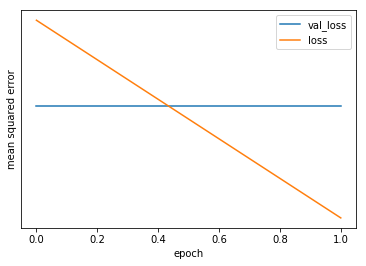

In [0]:
for value in ['val_loss', 'loss']:
    plt.semilogy(history[value],label = value)
#     plt.loglog(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

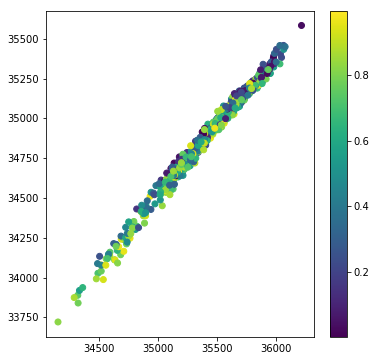

In [0]:
x_test_encoded = encoder.predict(X_test, batch_size=8)
plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test[:,0])
plt.colorbar()
plt.show()

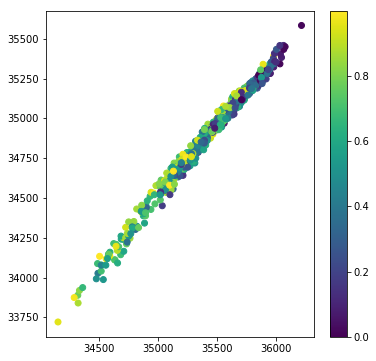

In [0]:
x_test_encoded = encoder.predict(X_test, batch_size=8)
plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test[:,1])
plt.colorbar()
plt.show()

### show original and predicted image side by side

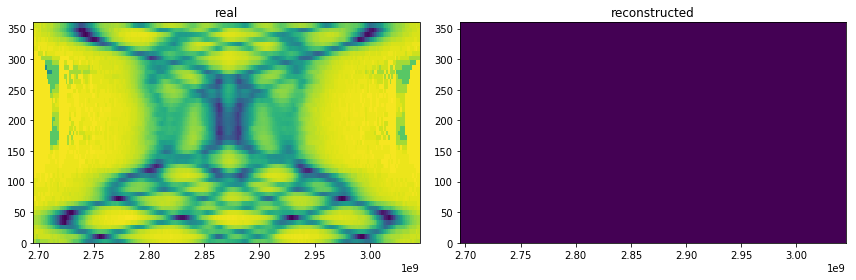

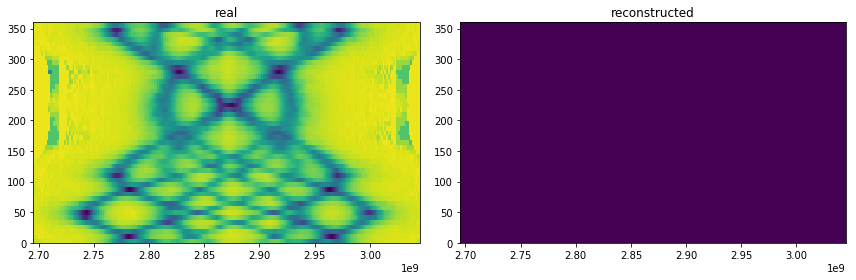

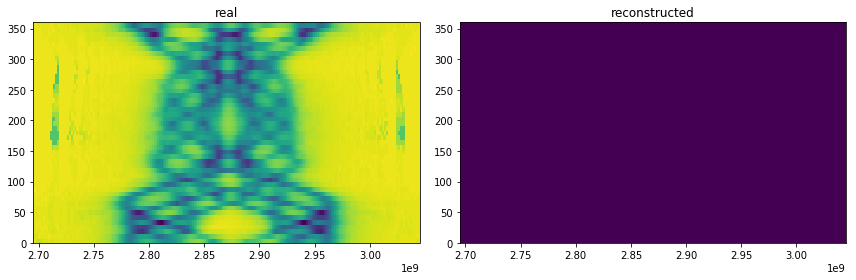

In [0]:
n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

# x_shape = X_train[0:n_plot, :,:,0].shape
# X_real = X_train[0:n_plot].reshape(x_shape[0], -1).reshape(x_shape)
X_real = X_train[0:n_plot]

frequencies = frequencies[0:X_real.shape[2]]
angle = angle[0:X_real.shape[1]]


def rescale(img, x_scaler):
    x_shape = img.shape
    return x_scaler.inverse_transform(img).reshape(x_shape)



for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    
    x_demo = X_real[i]
    pred = vae.predict(np.expand_dims(x_demo, axis=0))

    ax[0].pcolor(frequencies, angle, x_demo[:,:,0])
    ax[0].set_title('real')
    # and create the image, construction in second argument constructs the updates parameter dictionary
    ax[1].pcolor(frequencies, angle, pred[0,:,:,0])
    ax[1].set_title('reconstructed')
    plt.tight_layout()


### save autoencode

In [0]:
vae.save('../models/'+tag+'_vae.h5')
print('../models/' + time_stamp + '_' +tag+'_vae.h5 saved')

../models/20190126_shot_noise_0_xyztp_vae.h5 saved


### train a denoising autoencoder

In [0]:
# # add some noise
# noise_factor = 0.5
# X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
# X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
# X_val_noisy = val_data['X'] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_data['X'].shape)
# X_train_noisy = np.clip(X_train_noisy, 0., 1.)
# X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)
# X_val_noisy = np.clip(X_val_noisy, 0., 1.)

In [0]:
# vae, encoder, decoder = define_net(
#     False, img_height, img_width, batch_size=8, latent_dim=256, start_filters=8)

In [0]:
# class LossHistory(Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []

#     def on_batch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))

# # Set callback functions to early stop training and save the best model so far
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3),
#     ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
#     LossHistory(),
#     TQDMNotebookCallback(leave_inner=False, leave_outer=True)
# ]

# history = vae.fit(X_train_noisy, X_train, epochs=32, batch_size=32,verbose=0,
# #                     validation_split=0.2,
#                     validation_data=(X_test_noisy, X_test),
#                     callbacks=callbacks)

## simple autoencoder

In [0]:

def make_autoencoder(width, height, inChannel, latent_dim=32):
    
#     first_filter = (3, 3 * (height//width))
#     first_strides = (1,  (height//width))
    
    first_filter = (3, 3 )
    first_strides = (1,  1)
    
    print('first_filter', first_filter)
    print('first_strides', first_strides)
    input_img = Input(shape = (width, height, inChannel))
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    encoder = Conv2D(32, first_filter,strides=first_strides, activation='relu', padding='same')(input_img) #28 x 28 x 32
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #14 x 14 x 32
    encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder) #14 x 14 x 64
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder) #7 x 7 x 128 (small and thick)
    
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder) #7 x 7 x 128 (small and thick)
    
    #bottle neck
    shape = encoder.shape.as_list()[1:]
    print('shape', shape)

    encoder = Flatten()(encoder)
    encoder = Dense(latent_dim)(encoder)
    
    decoded = Dense(np.prod(shape), activation='relu')(encoder)
    decoded = Reshape(shape)(decoded)
    

    #decoder
    decoded = Conv2D(256, (3, 3), activation='relu', padding='same')(decoded) #7 x 7 x 128
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded) #7 x 7 x 128
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded) # 14 x 14 x 64
    decoded = UpSampling2D((2,2))(decoded) # 28 x 28 x 64
#     decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded) # 28 x 28 x 1
    decoded = Conv2D(1, (3, 3),padding='same')(decoded) # 28 x 28 x 1

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')  # RMSprop
    
#     autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder, encoder



def make_autoencoder_batchnorm(width, height, inChannel, latent_dim=32):
    
#     first_filter = (3, 3 * (height//width))
#     first_strides = (1,  (height//width))
    
    first_filter = (3, 3 )
    first_strides = (1,  1)
    
    print('first_filter', first_filter)
    print('first_strides', first_strides)
    input_img = Input(shape = (width, height, inChannel))
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    encoder = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_img) #28 x 28 x 32
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #14 x 14 x 32
    
    encoder = Conv2D(64, (3, 3), padding='same')(encoder) #14 x 14 x 64
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    
    encoder = Conv2D(128, (3, 3),padding='same')(encoder) #7 x 7 x 128 (small and thick)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder) #7 x 7 x 64
    encoder = Conv2D(256, (3, 3), padding='same')(encoder) #7 x 7 x 128 (small and thick)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)

    #decoder
    decoded = Conv2D(256, (3, 3), padding='same')(encoder) #7 x 7 x 128
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(128, (3, 3), padding='same')(decoded) #7 x 7 x 128
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    decoded = UpSampling2D((2,2))(decoded) # 14 x 14 x 128
    decoded = Conv2D(64, (3, 3), padding='same')(decoded) # 14 x 14 x 64
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    decoded = UpSampling2D((2,2))(decoded) # 28 x 28 x 64
#     decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded) # 28 x 28 x 1
    decoded = Conv2D(1, (3, 3),padding='same')(decoded) # 28 x 28 x 1

    autoencoder = Model(input_img, decoded)
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')  # RMSprop
    
#     autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder, encoder




# autoencoder = Sequential()

# # Encoder Layers
# autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=X_train2.shape[1:]))
# autoencoder.add(MaxPooling2D((2, 2), padding='same'))
# autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# autoencoder.add(MaxPooling2D((2, 2), padding='same'))
# autoencoder.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))

# # Flatten encoding for visualization
# # autoencoder.add(Flatten())
# # autoencoder.add(Reshape((4, 4, 8)))

# # Decoder Layers
# autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# autoencoder.add(UpSampling2D((2, 2)))
# autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# autoencoder.add(UpSampling2D((2, 2)))
# autoencoder.add(Conv2D(8, (3, 3), activation='relu'))
# autoencoder.add(UpSampling2D((2, 2)))
# autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))


autoencoder, encoder = make_autoencoder_batchnorm(*X.shape[1:], latent_dim=3)
autoencoder.summary()



first_filter (3, 3)
first_strides (1, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 48, 224, 1)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 48, 224, 32)       288       
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 224, 32)       128       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 224, 32)       0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 24, 112, 32)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 24, 112, 64)       18496     
_________________________________________________________________
batch_normalization_3 (Batch (None,

In [0]:

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=1),
#     ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
#     LossHistory(),
    TQDMNotebookCallback(leave_inner=False, leave_outer=True)
#     TensorBoard(log_dir='/tmp/autoencoder')
    
]

    

history = autoencoder.fit(X_train,X_train, epochs=3, batch_size=32,verbose=0,
                          shuffle=True,
                        validation_data=(X_test, X_test),
                        callbacks=callbacks)

In [0]:
autoencoder.history.history

{'val_loss': [0.13028488373756408, 0.09363042771816253, 0.0680879579782486],
 'loss': [6.6278586192727085, 0.02853505022989379, 0.020841548615031773]}

Text(0,0.5,'mean squared error')

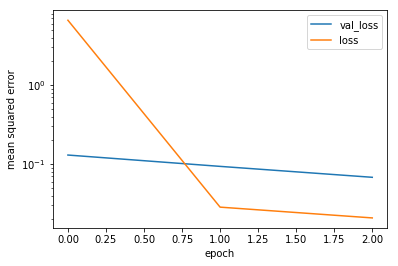

In [0]:
for value in ['val_loss', 'loss']:
    plt.semilogy(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

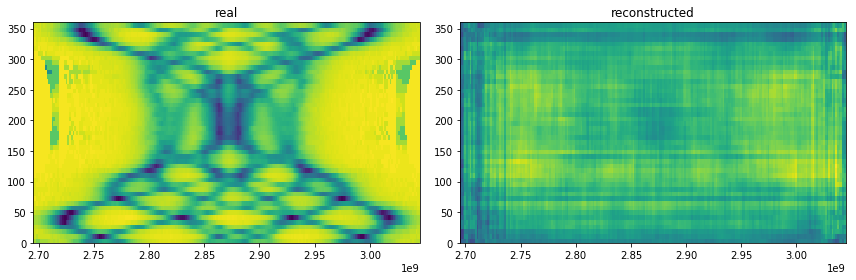

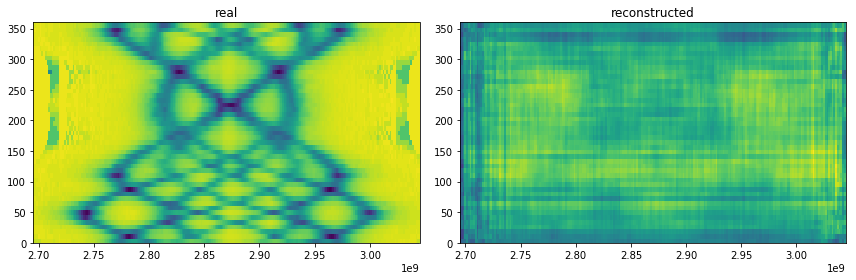

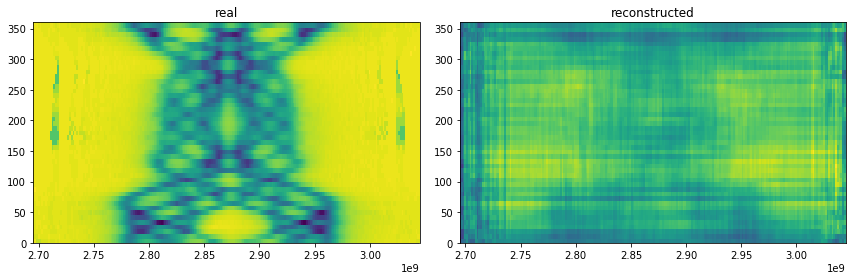

In [0]:
n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

# x_shape = X_train[0:n_plot, :,:,0].shape
# X_real = X_train[0:n_plot].reshape(x_shape[0], -1).reshape(x_shape)
X_real = X_train[0:n_plot]

frequencies = frequencies[0:X_real.shape[2]]
angle = angle[0:X_real.shape[1]]

for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    
    x_demo = X_real[i]
    pred = autoencoder.predict(np.expand_dims(x_demo, axis=0))

    ax[0].pcolor(frequencies, angle, x_demo[:,:,0])
    ax[0].set_title('real')
    # and create the image, construction in second argument constructs the updates parameter dictionary
    ax[1].pcolor(frequencies, angle, pred[0,:,:,0])
    ax[1].set_title('reconstructed')
    plt.tight_layout()


### save simple AE

In [0]:
autoencoder.save('../models/'+tag+'_simple-ae.h5')
print('../models/' + time_stamp + '_' +tag+'_simple-ae.h5 saved')

../models/20190126_shot_noise_0_xyztp_simple-ae.h5 saved


### show encoded representation

In [0]:
# n = 10
# plt.figure(figsize=(20, 8))
# for i in range(n):
#     ax = plt.subplot(1, n, i)
#     plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

# Save current notebook as HTML

In [0]:
time_stamp = time.strftime('%Y%m%d-%H%M', time.localtime()) 
time_stamp

'20190129-2126'

In [0]:
from IPython.display import Javascript

def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [0]:
%%time
import time
save_notebook()
time.sleep(3)
current_file = str(path_ipynb/'CNN - reconstruct magnet position from esr spectra.ipynb')
output_file = str(path_html/(time_stamp + '_' + tag + '.html'))
output_HTML(current_file, output_file)
print(output_file + ' saved')

/content/gdrive/My Drive/Colab Notebooks/html/20190129-2126_shot_noise_0_xyztp.html saved
CPU times: user 946 ms, sys: 8.01 ms, total: 954 ms
Wall time: 4.25 s
